## LLM

In [4]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [2]:
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [5]:
tokenizer = pkl.load(open("tokenizers/tokenizer_CNN16000_lowercase.pkl", 'rb'))
tokenizer.create_hash()

random.seed(42)
corpus_indicies = pkl.load(open('corpus/CNN_tokenized16000_lowercase.pkl', 'rb'))
random.shuffle(corpus_indicies)

## Define Model

In [6]:
class WarmUpThenDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                 initial_learning_rate: float,
                 warmup_steps: int,
                 decay_schedule_fn: tf.keras.optimizers.schedules.LearningRateSchedule):
        """
        initial_learning_rate: peak LR reached at end of warmup
        warmup_steps:      # of steps to ramp from 0 → initial_learning_rate
        decay_schedule_fn: a tf.keras schedule to apply *after* warmup
        """
        super().__init__()
        self.initial_lr = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_schedule_fn = decay_schedule_fn

    def __call__(self, step):
        # Cast to float32 for safety in graph mode
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # compute linear warmup: lr = initial_lr * (step / warmup_steps)
        warmup_lr = self.initial_lr * (step / warmup_steps)

        # after warmup_steps, switch to decay schedule (shift step count)
        decay_step = step - warmup_steps
        decay_lr = self.decay_schedule_fn(decay_step)

        # if step < warmup_steps, pick warmup_lr, else decay_lr
        return tf.cond(step < warmup_steps,
                       lambda: warmup_lr,
                       lambda: decay_lr)
    


In [7]:
initial_lr = 1e-4
decay_steps = 50000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 10000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 200
embed_dim = 1024
tf_blocks = 8
heads = 8
ff_dim = 4*embed_dim

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    lr=lr_schedule,
                    wd = 0.01,
                    )

losses_train = []
losses_test = []


In [8]:
name = "model_16k_tokens_lowercase_8blocks_wt"


ckpt = tf.train.Checkpoint(
    optimizer=model.optimizer,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [280]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [200]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 117413574


In [ ]:
batch_size = 8
for i in tqdm(range(100000)):
    indices, y_true = sample_batch(corpus_indicies[:90000], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    
    loss_train = model.train_step(indices, y_true).numpy()
    losses_train.append(loss_train)


    if i % 10 == 0:
        indices, y_true = sample_batch(corpus_indicies[90000:], 
                                    batch_size, 
                                    tokenizer, 
                                    max_seq_len)
        
        loss_test = model.evaluate(indices, y_true).numpy()
        
    losses_test.append(loss_test)

    if (i+1) % 1000 == 0:
        ckpt_manager.save()
        pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

    clear_output(wait=True)

    # prepare x-axis for the last 400 steps
    start = max(0, len(losses_train) - 1000)
    x_zoom = np.arange(start, len(losses_train))

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    # Top subplot: zoom on last 400 steps
    ax1 = axes[0]
    ax1.plot(x_zoom, losses_test[-1000:], label="Test Loss")
    ax1.plot(x_zoom, losses_train[-1000:], label="Train Loss")

    _min = min(losses_train[-1000:] + losses_test[-1000:])
    _max = max(losses_train[-1000:] + losses_test[-1000:])
    delta = _max - _min
    ax1.set_ylim(_min - 0.1 * delta, _max + 0.1 * delta)

    ax1.set_title("Training Loss (Last 1000 Steps)")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Bottom subplot: full series
    ax2 = axes[1]
    ax2.plot(losses_test, label="Test Loss")
    ax2.plot(losses_train, label="Train Loss")

    ax2.set_title("Training Loss (Full Series)")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

  0%|          | 0/100000 [00:00<?, ?it/s]

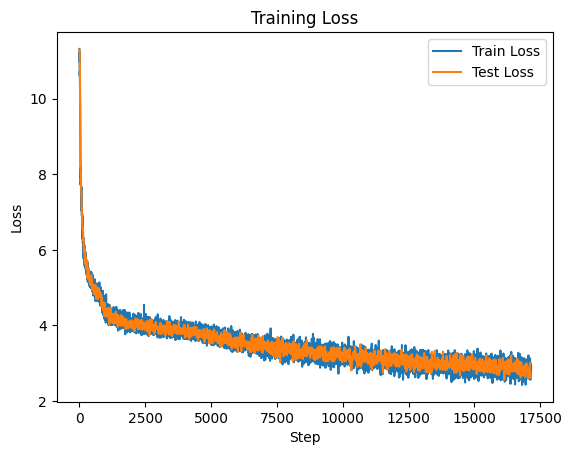

In [202]:
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [203]:
def tokenize(indices, merge_list):
    indices = np.array(indices)
    for pair, new_idx in merge_list:
        slice = np.where(np.logical_and(indices[:-1] == pair[0],  indices[1:] == pair[1]))
        if len(slice[0]) > 0:
            indices[:-1][slice] = new_idx
            indices = np.delete(indices, (slice[0]+1))

    return tf.expand_dims(tf.convert_to_tensor(indices, dtype=tf.int32), axis=0)

In [204]:
text = "The optimal resolution to the Palestinian-Israeli conflict is"
text = text.lower()

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

tf.Tensor(
[[  72    1 5447   82    1 4265    1   83    1   72    1 3351   14 2402
     1 2687    1   88]], shape=(1, 18), dtype=int32)


In [205]:
T = 0.5
tf.random.set_seed(42)
for i in range(200):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


KeyboardInterrupt: 

In [276]:
from sklearn.cluster import KMeans

def cosine_similarity(embed_a, embed_b):
    """
    Compute the cosine similarity between two vectors.
    """
    embed_b_T = tf.transpose(embed_b)
    dot_product = embed_a@embed_b_T
    
    norm_a = tf.linalg.norm(embed_a, axis=1, keepdims=True)
    norm_b = tf.linalg.norm(embed_b_T, axis=0, keepdims=True)

    return dot_product / (norm_a * norm_b)


def cluster(X, n_clusters):
    X = X/np.linalg.norm(X, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_

    return inertia, labels, clusters


class EmbeddingClustering:
    def __init__(self, tokenizer, n_clusters=10):
        
        self.tokenizer = tokenizer
        self.n_clusters = n_clusters

    def fit(self, word_embed):
        inertia, labels, clusters = cluster(word_embed, self.n_clusters)
        self.word_embed = word_embed
        self.inertia = inertia
        self.labels = labels
        self.clusters = tf.convert_to_tensor(clusters, dtype=tf.float32)

        cos_sim = cosine_similarity(self.clusters, word_embed)
        idx_list =  tf.argsort(cos_sim, axis=-1, direction='DESCENDING', stable=False, name=None)

        for idx in idx_list:
            for i in idx[:6]:
                word = self.tokenizer.detokenize(tf.expand_dims(tf.cast(i, tf.int32), axis=0))
                word = word.numpy().decode('utf-8')
                print(word)
            print("\n")

In [278]:
word_embed = model.word_embed

embedding_clustering = EmbeddingClustering(tokenizer, n_clusters=20)
embedding_clustering.fit(word_embed)

immen
sterdam
setts
portugu
hawar
hurrican


uguay
recor
0s
hezbol
mingham
portugu


streng
adjac
uguay
environ
inev
emerg


shaba
eleph
hezbol
{
recor
mingham


l
cl
mu
z
kh
cr


streng
attem
citiz
injiang
massachu
emerg


dipl
citiz
subjected
acare
resul
immen


situation
company
problem
investigation
service
response


citiz
mogad
assaul
wawrink
abulary
portugu


convince
comply
interfere
satisfy
citiz
implement


assaul
hurrican
sterdam
massachu
citiz
portra


abulary
mingham
citiz
dipl
alep
environ


letting
comparing
violating
granting
sparking
highlighting


secur
ivid
recor
raik
debor
issip


gonna
mogad
it'll
immen
endum
necessarily


citiz
recor
uguay
raik
adjac
hezbol


damasc
0s
hurrican
prede
mingham
portugu


buenos
kuala
197
195
190
135


mingham
propof
guate
eleph
environ
alep


a
in
the
to
for
and




## 